In [58]:
import os
import pandas as pd
import librosa
import librosa.display
import glob
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
import struct
import webrtcvad

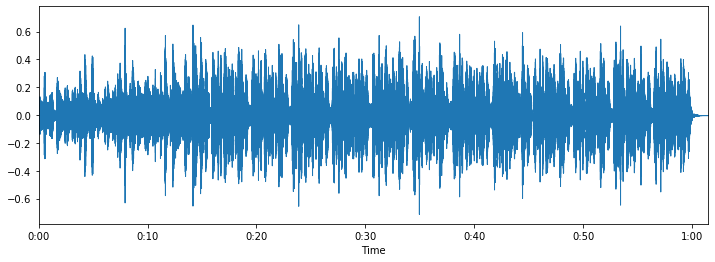

In [33]:
# data, sampling_rate = librosa.load('./2022.wav')
data, sampling_rate = librosa.load(librosa.util.example_audio_file())
plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

In [34]:
yt, index = librosa.effects.trim(data)
print(librosa.get_duration(data), librosa.get_duration(yt))

61.45886621315193 60.60408163265306


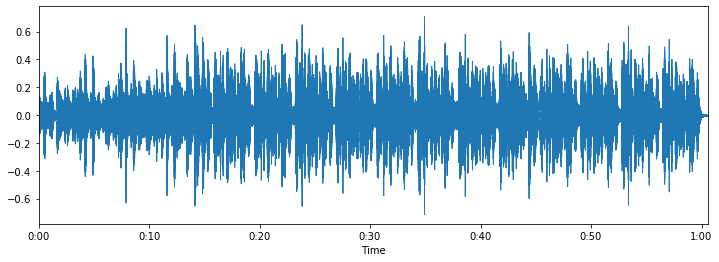

In [35]:
plt.figure(figsize=(12, 4))
librosa.display.waveplot(yt, sr=sampling_rate)

In [63]:
def trim_long_silences(wav):
    vad_window_length = 30
    vad_moving_average_width = 8
    vad_max_silence_length = 6
    int16_max = (2 ** 15) - 1
    samples_per_window = (vad_window_length * sampling_rate) // 1000
    wav = wav[:len(wav) - (len(wav) % samples_per_window)]
    pcm_wave = struct.pack("%dh" % len(wav), *(np.round(wav * int16_max)).astype(np.int16))
    voice_flags = []
    vad = webrtcvad.Vad(mode=3)
    for window_start in range(0, len(wav), samples_per_window):
        window_end = window_start + samples_per_window
        voice_flags.append(vad.is_speech(pcm_wave[window_start * 2:window_end * 2],
                                         sample_rate=sampling_rate))
    voice_flags = np.array(voice_flags)
    
    # Smooth the voice detection with a moving average
    def moving_average(array, width):
        array_padded = np.concatenate((np.zeros((width - 1) // 2), array, np.zeros(width // 2)))
        ret = np.cumsum(array_padded, dtype=float)
        ret[width:] = ret[width:] - ret[:-width]
        return ret[width - 1:] / width
    
    audio_mask = moving_average(voice_flags, vad_moving_average_width)
    audio_mask = np.round(audio_mask).astype(np.bool)
    
    # Dilate the voiced regions
    audio_mask = binary_dilation(audio_mask, np.ones(vad_max_silence_length + 1))
    audio_mask = np.repeat(audio_mask, samples_per_window)
    
    return wav[audio_mask == True]

data = trim_long_silences(data)

Error: Error while processing frame

In [50]:
def normalize_volume(wav, target_dBFS, increase_only=False, decrease_only=False):
    dBFS_change = target_dBFS - 10 * np.log10(np.mean(wav ** 2))
    if (dBFS_change < 0 and increase_only) or (dBFS_change > 0 and decrease_only):
        return wav
    return wav * (10 ** (dBFS_change / 20))

data = normalize_volume(data, 30, increase_only=True)

In [51]:
ipd.Audio(data, rate=sampling_rate)

In [52]:
S = librosa.feature.melspectrogram(y=data, sr=sampling_rate)

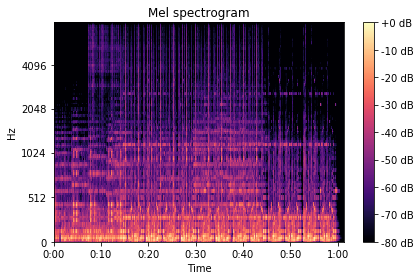

In [53]:
librosa.display.specshow(librosa.power_to_db(S,                                              
ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()

In [55]:
!pip install webrtcvad

Processing c:\users\gvn sai uday\appdata\local\pip\cache\wheels\44\2a\18\bd1aec41cac7c3051fe95d92a6ed446122ea31dc713c432fa1\webrtcvad-2.0.10-cp36-cp36m-win_amd64.whl
